In [1]:
from IPython.display import HTML

# Data
###craigslist has ~300 rental listings in SD (better sources?)
school's apartment resources:
+ http://offcampushousing.ucsd.edu/media/apartmentmap08_front.pdf
+ http://offcampushousing.ucsd.edu/media/apartmentmap08_back.pdf

In [37]:
# relevant listings
CL_SD_apartment_rent_search_urls = ['https://sandiego.craigslist.org/search/apa?is_paid=all&search_distance_type=mi&query=ucsd',
                                    'https://sandiego.craigslist.org/search/apa?s=100&is_paid=all&query=ucsd&search_distance_type=mi',
                                    'https://sandiego.craigslist.org/search/apa?s=200&is_paid=all&query=ucsd&search_distance_type=mi',
                                    'https://sandiego.craigslist.org/search/apa?s=300&is_paid=all&query=ucsd&search_distance_type=mi']

In [83]:
# start scraping webdata
import urllib2
from bs4 import BeautifulSoup

price_and_bedroom_and_location_span_tags = []
listing_url_tags = []

for CL_SD_apartment_rent_search_url in CL_SD_apartment_rent_search_urls:
    response = urllib2.urlopen(CL_SD_apartment_rent_search_url)
    soup = BeautifulSoup(response.read(), 'html.parser')
    price_and_bedroom_and_location_span_tags += soup.find_all("span", class_="l2")
    listing_url_tags += soup.find_all("a", class_="hdrlnk")

In [116]:
# wrangle webdata into csv formatted dataset
DATASET_NAME = 'cl_sd_apa_rentals.csv'

import re
price_regex_pattern   = re.compile("\$(\d+)")
bedroom_regex_pattern = re.compile("\dbr")
location_regex_pattern= re.compile("\(.*\)")

import csv

with open(DATASET_NAME, 'wb') as csvfile:
    HEADER = ['price', 'n_bedrooms', 'place', 'url', 'address']
    cl_sd_apa_rentals_writer = csv.writer(csvfile, delimiter='\t')
    cl_sd_apa_rentals_writer.writerow(HEADER)
    
    N = len(price_and_bedroom_and_location_span_tags)
    
    for i in range(N):
        p_and_b_and_l_tag = price_and_bedroom_and_location_span_tags[i]
        price_node = p_and_b_and_l_tag.find("span", class_="price")
        bedroom_node = p_and_b_and_l_tag.find("span", class_="housing")
        location_node = p_and_b_and_l_tag.find("small")
        
        price = ''
        n_bedrooms = ''
        place = ''
        url = ''
        address = ''
        
        if price_node:
            r = price_regex_pattern.search(price_node.getText())
            
            if r:
                price = r.group(0)
        
        if bedroom_node:
            r = bedroom_regex_pattern.search(bedroom_node.getText())
            
            if r:
                n_bedrooms = r.group(0)
            
        if location_node:
            r = location_regex_pattern.search(location_node.getText())
            
            if r:
                place = r.group(0)
                place = place.strip('()')
                
        if listing_url_tags[i]['href']:
            url = 'https://sandiego.craigslist.org/' + listing_url_tags[i]['href']
            
            response = urllib2.urlopen(url)
            soup = BeautifulSoup(response.read(), 'html.parser')
            mapaddress_tag = soup.find_all('div', class_='mapaddress')

            if mapaddress_tag:
                address = mapaddress_tag[0].getText()
            
        row = [price, n_bedrooms, place, url, address]
        cl_sd_apa_rentals_writer.writerow(row)

In [118]:
import pandas as pd

df = pd.read_csv(DATASET_NAME, delimiter='\t')
df.head(10)

,price,n_bedrooms,place,url,address
0,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54500...,3520 Lebon Dr.
1,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54219...,3520 Lebon Dr.
2,$4600,6br,"San Diego,Clairmont, UCSD, Unv. City",https://sandiego.craigslist.org//csd/apa/54526...,NaN
3,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54520...,3520 Lebon Dr.
4,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54358...,3520 Lebon Dr.
5,$3400,3br,La Jolla/UCSD,https://sandiego.craigslist.org//csd/apa/54509...,8274 Caminito Sonoma
6,$2700,3br,UCSD-UTC,https://sandiego.craigslist.org//csd/apa/54509...,caminito modena at caminito sonoma
7,$2300,3br,UTC-UCSD,https://sandiego.craigslist.org//csd/apa/54509...,vision drive at easter way
8,$1599,1br,UCSD / UTC / La Jolla,https://sandiego.craigslist.org//csd/apa/54342...,nobel at lebon
9,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54508...,3520 Lebon Dr.


##Estimating Distance with MapsApi
tutorial https://developers.google.com/maps/documentation/distance-matrix/intro
####(Assume transit mode is bus)
create unique api key credentials https://developers.google.com/maps/documentation/distance-matrix/get-api-key

In [171]:
API_KEY_FILENAME = 'mapsapikeyfile'
api_key = ''

with open (API_KEY_FILENAME, "r") as myfile:
    first_line = myfile.readlines()[0]
    api_key = first_line.strip()

In [260]:
is_missing_address = df.address.apply(pd.isnull)
our_dataset_with_full_addresses_only = df[~is_missing_address]

In [265]:
from requests.compat import quote_plus
import json

distances_in_miles = []
times_in_minutes = []

SCHOOL_ADDRESS = '9500 Gilman Dr, La Jolla CA'
MAX_ELEMENTS_QUERYABLE_PER_REQUEST = 100

rental_addresses = our_dataset_with_full_addresses_only.address

def fix_rental_addresses_strings(rental_addresses):
    rental_addresses = rental_addresses.apply(lambda a : quote_plus(a[:a.index('at')] + ', San Diego' if 'at' in a else a))
    rental_addresses = map(lambda a : quote_plus(SCHOOL_ADDRESS) if len(a) <= 5 else a, rental_addresses)
    return rental_addresses

rental_addresses = fix_rental_addresses_strings(rental_addresses)
rental_addresses_encoded_as_get_parameters = '|'.join(rental_addresses)

parameters = {'transit_mode': 'bus',
             'destinations': quote_plus(SCHOOL_ADDRESS),
             'key': api_key,
             'units': 'imperial'}

maps_api_base_url = "https://maps.googleapis.com/maps/api/distancematrix/json?"
origin_addresses_chunk_size = MAX_ELEMENTS_QUERYABLE_PER_REQUEST/2

for i in range(0, len(rental_addresses), origin_addresses_chunk_size):
    parameters['origins'] = '|'.join(rental_addresses_encoded_as_get_parameters.split('|')[i:i+origin_addresses_chunk_size])
    query = maps_api_base_url + '&'.join(['{key}={val}'.format(key=k, val=v) for k,v in parameters.items()])
    #print query
    #print 
    response = urllib2.urlopen(query)
    time_distance_data = json.loads(response.read())
    
    def get_distance_or_duration(maps_api_result_row, distance_or_duration='distance'):
        if distance_or_duration in r['elements'][0]:
            return r['elements'][0][distance_or_duration]['text']
        else:
            return ''
    
    distances_in_miles += [get_distance_or_duration(r, 'distance') for r in time_distance_data['rows']]
    times_in_minutes += [get_distance_or_duration(r, 'duration') for r in time_distance_data['rows']]

In [272]:
our_dataset_with_full_addresses_only['distance'] = distances_in_miles
our_dataset_with_full_addresses_only['time'] = times_in_minutes

/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [345]:
our_dataset_with_full_addresses_only.to_csv(DATASET_NAME, sep='\t', index=False)
our_dataset_with_full_addresses_only = pd.read_csv(DATASET_NAME, sep='\t')
our_dataset_with_full_addresses_only.ix[0:5]

,price,n_bedrooms,place,url,address,distance,time
0,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54500...,3520 Lebon Dr.,2.6 mi,8 mins
1,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54219...,3520 Lebon Dr.,2.6 mi,8 mins
2,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54520...,3520 Lebon Dr.,2.6 mi,8 mins
3,$1995,1br,"UTC, La Jolla, UCSD, San Diego",https://sandiego.craigslist.org//csd/apa/54358...,3520 Lebon Dr.,2.6 mi,8 mins
4,$3400,3br,La Jolla/UCSD,https://sandiego.craigslist.org//csd/apa/54509...,8274 Caminito Sonoma,3.0 mi,8 mins
5,$2700,3br,UCSD-UTC,https://sandiego.craigslist.org//csd/apa/54509...,caminito modena at caminito sonoma,3.2 mi,9 mins


In [346]:
our_dataset_with_full_addresses_only['price'] = our_dataset_with_full_addresses_only.price.apply(lambda p : int(p[1:]))
our_dataset_with_full_addresses_only['distance'] = our_dataset_with_full_addresses_only.distance.apply(lambda d : float(d.split()[0].replace(',', '') if isinstance(d, basestring) else 0))
our_dataset_with_full_addresses_only['time'] = our_dataset_with_full_addresses_only.time.apply(lambda t : int(t.split()[0] if isinstance(t, basestring) else 0))
our_dataset_with_full_addresses_only['n_bedrooms'] = our_dataset_with_full_addresses_only.n_bedrooms.apply(lambda n_bedroom : int(n_bedroom.strip('br') if isinstance(n_bedroom, basestring) else 0))

In [347]:
our_dataset_with_full_addresses_only.describe()

,price,n_bedrooms,distance,time
count,282.000000,282.000000,282.000000,282.000000
mean,2042.365248,1.677305,73.808156,11.673759
std,745.387266,0.903994,384.168301,5.633525
min,195.000000,0.000000,0.000000,0.000000
25%,1620.000000,1.000000,2.600000,8.000000
50%,1850.000000,2.000000,3.500000,10.000000
75%,2300.000000,2.000000,7.225000,14.750000
max,6000.000000,5.000000,3121.000000,28.000000


##Estimating Cost by Metric
###PPBI: price per bedroom index
(methodology utilized by Trulia maps)

In [4]:
trulia_article = "http://sf.curbed.com/archives/2013/09/16/trulias_interactive_map_of_rental_prices_shows_san_francisco_as_one_big_redzone.php"
HTML("<iframe src='{0}' height=500 width=700></iframe>".format(trulia_article))

In [348]:
our_dataset_with_full_addresses_and_n_bedrooms_only = our_dataset_with_full_addresses_only[our_dataset_with_full_addresses_only.n_bedrooms > 0]
our_dataset_with_full_addresses_and_n_bedrooms_only['ppbi'] = our_dataset_with_full_addresses_and_n_bedrooms_only.price / our_dataset_with_full_addresses_and_n_bedrooms_only.n_bedrooms

/home/kevin/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


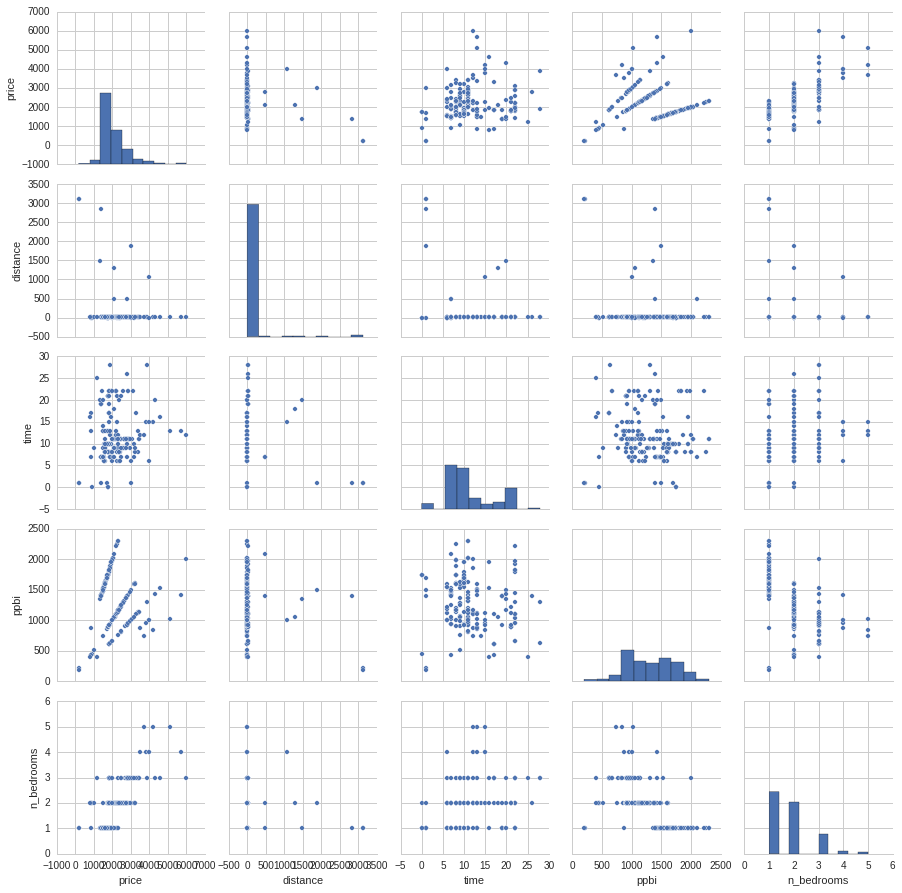

In [352]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")

sns.pairplot(our_dataset_with_full_addresses_and_n_bedrooms_only[['price', 'distance', 'time', 'ppbi', 'n_bedrooms']])
plt.show()

let's remove outliers according to the (ppbi, distance) plot, say rentals outside of 50 mi.

In [350]:
df = our_dataset_with_full_addresses_and_n_bedrooms_only[our_dataset_with_full_addresses_and_n_bedrooms_only.distance < 50]

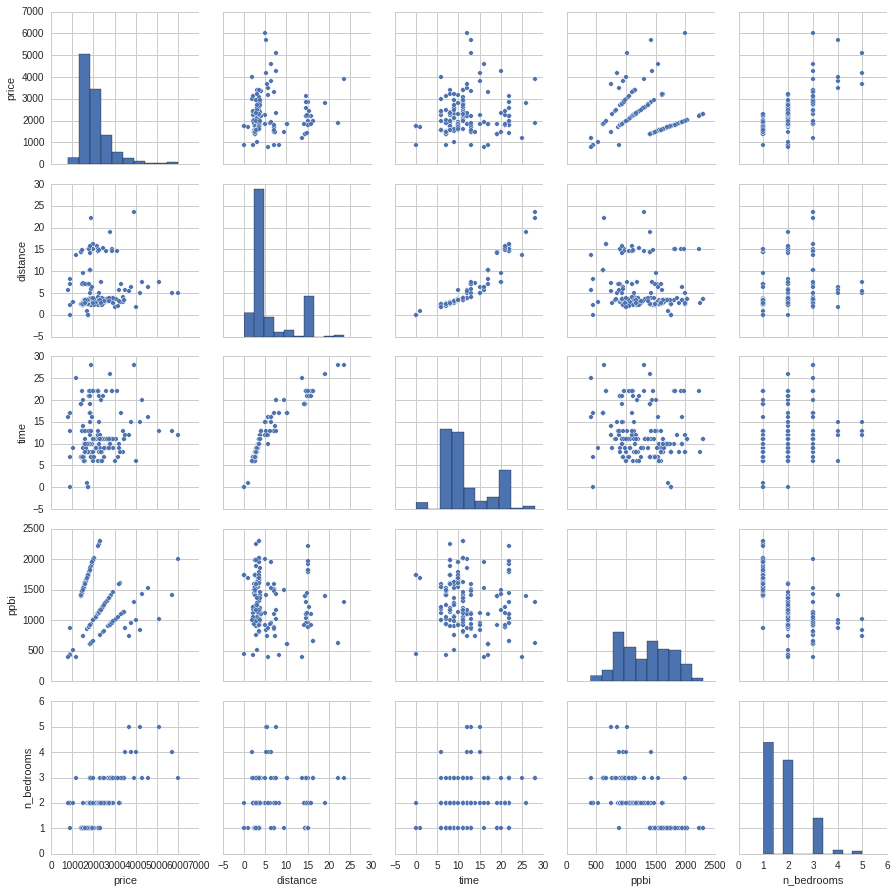

In [353]:
sns.pairplot(df[['price', 'distance', 'time', 'ppbi', 'n_bedrooms']])

time vs ppbi seems interesting..

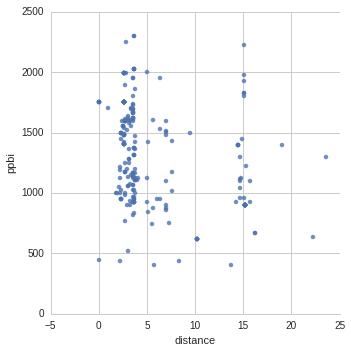

In [356]:
sns.lmplot("distance", "ppbi", data=df, fit_reg=False)

distance or time? interchangeable, with linear regression equation

In [510]:
import statsmodels.formula.api as sm

result = sm.ols(formula="time ~ distance- 1", data=df).fit()
print result.params
print result.summary()

distance    1.640796
dtype: float64
                            OLS Regression Results                            
Dep. Variable:                   time   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     2413.
Date:                Sun, 21 Feb 2016   Prob (F-statistic):          2.85e-133
Time:                        22:12:02   Log-Likelihood:                -733.23
No. Observations:                 260   AIC:                             1468.
Df Residuals:                     259   BIC:                             1472.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
distance       1

$$ \textrm{minutes on bus} = f(\textrm{miles from UCSD}) \simeq 1.7 \cdot \textrm{miles from UCSD}$$

OK, now let's use Kmeans to find groups in our dataset

use feature normalization on our design matrix
http://stats.stackexchange.com/a/70807

$$z_i = {{x_i - \textrm{min}(x)} \over {\textrm{max}(x) - \textrm{min}(x)}}$$

In [485]:
X = df[['distance', 'ppbi']].as_matrix()
X = np.array(X.tolist())

from sklearn.cluster import KMeans
import numpy as np

def normalize(vector):
    vector = ( np.array(vector) - min(vector) ) / max(vector) - min(vector)
    return vector

X_norm = X
X_norm[:,0] = normalize(X[:,0])# normalize distance/time
X_norm[:,1] = normalize(X[:,1])# normalize ppbi: price per bedroom index

K = 3
k_means = KMeans(n_clusters=K)
k_means.fit(X_norm)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

(3.728409090909092, 1007.1439393939396) 0
(3.1352941176470597, 1671.436274509804) 1
(14.873584905660385, 1060.5094339622642) 2


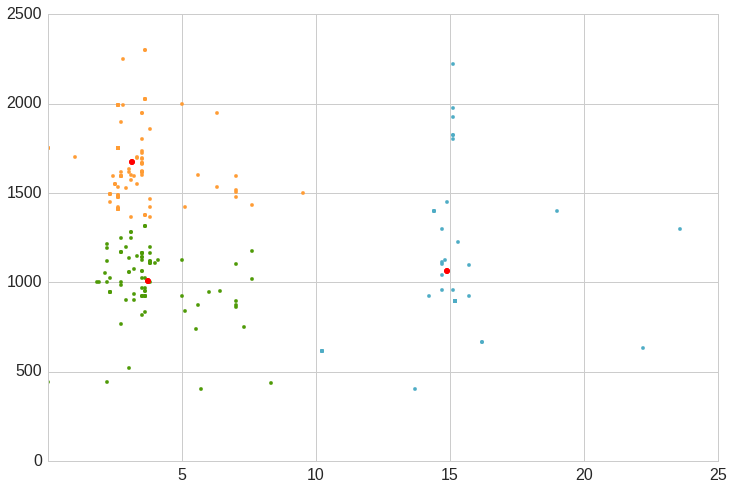

In [572]:
# Compute clustering with Means
k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_

# Plot result
fig = plt.figure(figsize=(12,8))

k_means_labels = k_means.labels_
k_means_cluster_centers = k_means.cluster_centers_
colors = ['#4E9A06', '#FF9C34', '#4EACC5']

import matplotlib.pyplot as plt

# KMeans
for k, col in zip(range(K), colors):
    my_members = k_means_labels == k
    cluster_center = df.distance[my_members].mean(), df.ppbi[my_members].mean()#k_means_cluster_centers[k]
    plt.scatter(df.distance[my_members], df.ppbi[my_members], #'w',
            color=col, marker='o', s=12)
    plt.plot(cluster_center[0], cluster_center[1], 'ro', markerfacecolor='red',
            markeredgecolor='k', markersize=6)

#fig.suptitle('San Diego Apartment Rentals ')
#plt.title('KMeans')

plt.xlim((0, 25))

ax = plt.gca()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(16)
    
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(16)

ax.set_xticklabels(['']+list(range(5,30,5)))
plt.show()

In [ ]:
kmean_labels_map = {0: 'near-cheap', 1: 'near-expensive', 2: 'far-cheap'}
df['group'] = map(lambda lab : kmean_labels_map[lab], k_means_labels)